# Введение в искусственные нейронные сети
# Урок 4. Сверточные нейронные сети

## Практическое задание
Вариант 1. 

* обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете fashion-mnist
* оценить рост точности при увеличении ширины сети (больше ядер)
* оценить рост точности при увеличении глубины сети (больше слоев)
* сравнить с точностью полносвязной сети для этой выборки


In [ ]:
import numpy as np

import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, losses, datasets
from tensorflow.keras.losses import categorical_crossentropy

import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)

x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)

x_val = x_train[-2000:,:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:,:]
y_train = y_train[:-2000]

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
# инициализация пустой модели

model = Sequential()

model.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:]))

model.add(layers.Conv2D(96, 11, strides=4, padding='same'))
model.add(layers.Lambda(tf.nn.local_response_normalization))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(3, strides=2))

model.add(layers.Conv2D(256, 5, strides=4, padding='same'))
model.add(layers.Lambda(tf.nn.local_response_normalization))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(3, strides=2))

model.add(layers.Conv2D(384, 3, strides=4, padding='same'))
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(384, 3, strides=4, padding='same'))
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(256, 3, strides=4, padding='same'))
model.add(layers.Activation('relu'))

# сглаживание CNN выхода для присоединения к полносвязному слою

model.add(layers.Flatten())

# первый полносвязный слой

model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))

# второй полносвязный слой

model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))

# выходной слой с функцией активации softmax

model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 56, 96)        34944     
_________________________________________________________________
lambda (Lambda)              (None, 56, 56, 96)        0         
_________________________________________________________________
activation (Activation)      (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 256)         614656    
_________________________________________________________________
lambda_1 (Lambda)            (None, 7, 7, 256)         0

In [ ]:
# компиляция модели

model.compile(optimizer='adam',
              loss=losses.sparse_categorical_crossentropy, 
              metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train, 
                    batch_size=64, 
                    epochs=20, 
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
907/907 [==============================] - 64s 67ms/step - loss: 1.0238 - accuracy: 0.5758 - val_loss: 0.3729 - val_accuracy: 0.8690
Epoch 2/20
907/907 [==============================] - 60s 66ms/step - loss: 0.3372 - accuracy: 0.8767 - val_loss: 0.2929 - val_accuracy: 0.8910
Epoch 3/20
907/907 [==============================] - 60s 66ms/step - loss: 0.2926 - accuracy: 0.8949 - val_loss: 0.3111 - val_accuracy: 0.8780
Epoch 4/20
907/907 [==============================] - 60s 66ms/step - loss: 0.2664 - accuracy: 0.9060 - val_loss: 0.2742 - val_accuracy: 0.9060
Epoch 5/20
907/907 [==============================] - 60s 66ms/step - loss: 0.2386 - accuracy: 0.9134 - val_loss: 0.2927 - val_accuracy: 0.9005
Epoch 6/20
907/907 [==============================] - 60s 66ms/step - loss: 0.2258 - accuracy: 0.9191 - val_loss: 0.2552 - val_accuracy: 0.9125
Epoch 7/20
907/907 [==============================] - 60s 66ms/step - loss: 0.1989 - accuracy: 0.9280 - val_loss: 0.2497 - val_accuracy:

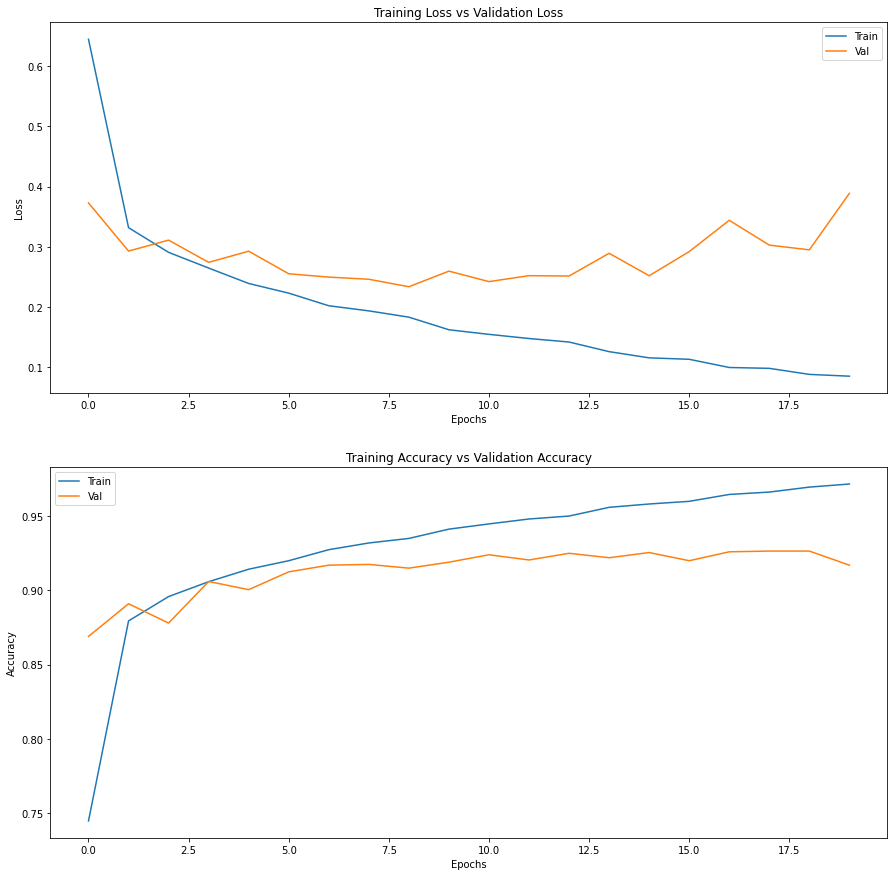

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
test_score = model.evaluate(x_test, y_test)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))


313/313 [==============================] - 4s 14ms/step - loss: 0.4343 - accuracy: 0.9080
Test loss 0.4343, accuracy 90.80%


### Оценка влияния увеличения ширины сети

In [ ]:
result_width = []

In [ ]:
def models_width(width_1=256, width_2=384, epochs=10):
    model = Sequential()

    model.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:]))

    model.add(layers.Conv2D(96, 11, strides=4, padding='same'))
    model.add(layers.Lambda(tf.nn.local_response_normalization))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(3, strides=2))

    model.add(layers.Conv2D(width_1, 5, strides=4, padding='same'))
    model.add(layers.Lambda(tf.nn.local_response_normalization))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(3, strides=2))

    model.add(layers.Conv2D(width_2, 3, strides=4, padding='same'))
    model.add(layers.Activation('relu'))

    model.add(layers.Conv2D(width_2, 3, strides=4, padding='same'))
    model.add(layers.Activation('relu'))

    model.add(layers.Conv2D(width_1, 3, strides=4, padding='same'))
    model.add(layers.Activation('relu'))

    # сглаживание CNN выхода для присоединения к полносвязному слою

    model.add(layers.Flatten())

    # первый полносвязный слой

    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # второй полносвязный слой

    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # выходной слой с функцией активации softmax

    model.add(layers.Dense(10, activation='softmax'))
    
    # компиляция модели

    model.compile(optimizer='adam',
                  loss=losses.sparse_categorical_crossentropy, 
                  metrics=['accuracy'])

    model.fit(x=x_train, y=y_train, 
                    batch_size=64, 
                    epochs=epochs, 
                    validation_data=(x_val, y_val),
                    verbose=1)
    
    [loss, accuracy] = model.evaluate(x_test, y_test)
    print("Test loss {:.4f}, accuracy {:.2f}%".format(loss, accuracy * 100))
    
    # накопление результатов
    
    result_width.append([width_1, width_2, loss, accuracy])
    
    return result_width

In [ ]:
models_width(256, 384, epochs=10)

Epoch 1/10
907/907 [==============================] - 60s 66ms/step - loss: 0.9484 - accuracy: 0.6128 - val_loss: 0.3600 - val_accuracy: 0.8650
Epoch 2/10
907/907 [==============================] - 60s 66ms/step - loss: 0.3433 - accuracy: 0.8782 - val_loss: 0.2759 - val_accuracy: 0.8935
Epoch 3/10
907/907 [==============================] - 60s 66ms/step - loss: 0.2968 - accuracy: 0.8936 - val_loss: 0.2661 - val_accuracy: 0.9030
Epoch 4/10
907/907 [==============================] - 60s 66ms/step - loss: 0.2664 - accuracy: 0.9034 - val_loss: 0.2640 - val_accuracy: 0.9040
Epoch 5/10
907/907 [==============================] - 60s 66ms/step - loss: 0.2358 - accuracy: 0.9137 - val_loss: 0.2521 - val_accuracy: 0.9100
Epoch 6/10
907/907 [==============================] - 60s 66ms/step - loss: 0.2250 - accuracy: 0.9212 - val_loss: 0.2399 - val_accuracy: 0.9180
Epoch 7/10
907/907 [==============================] - 59s 66ms/step - loss: 0.2003 - accuracy: 0.9273 - val_loss: 0.2484 - val_accuracy:

[[256, 384, 0.298981249332428, 0.9046000242233276]]

In [ ]:
models_width(384, 576, epochs=10)

Epoch 1/10
907/907 [==============================] - 66s 72ms/step - loss: 1.0437 - accuracy: 0.5673 - val_loss: 0.3430 - val_accuracy: 0.8750
Epoch 2/10
907/907 [==============================] - 65s 72ms/step - loss: 0.3467 - accuracy: 0.8764 - val_loss: 0.3306 - val_accuracy: 0.8800
Epoch 3/10
907/907 [==============================] - 65s 72ms/step - loss: 0.2854 - accuracy: 0.8984 - val_loss: 0.3099 - val_accuracy: 0.8865
Epoch 4/10
907/907 [==============================] - 65s 72ms/step - loss: 0.2569 - accuracy: 0.9072 - val_loss: 0.2559 - val_accuracy: 0.9100
Epoch 5/10
907/907 [==============================] - 64s 71ms/step - loss: 0.2393 - accuracy: 0.9153 - val_loss: 0.2839 - val_accuracy: 0.8985
Epoch 6/10
907/907 [==============================] - 65s 71ms/step - loss: 0.2095 - accuracy: 0.9257 - val_loss: 0.2620 - val_accuracy: 0.9075
Epoch 7/10
907/907 [==============================] - 65s 72ms/step - loss: 0.1937 - accuracy: 0.9319 - val_loss: 0.2412 - val_accuracy:

[[256, 384, 0.298981249332428, 0.9046000242233276],
 [384, 576, 0.27835166454315186, 0.9118000268936157]]

In [ ]:
models_width(576, 864, epochs=10)

Epoch 1/10
907/907 [==============================] - 77s 84ms/step - loss: 1.0113 - accuracy: 0.5801 - val_loss: 0.3356 - val_accuracy: 0.8715
Epoch 2/10
907/907 [==============================] - 75s 83ms/step - loss: 0.3393 - accuracy: 0.8794 - val_loss: 0.2875 - val_accuracy: 0.8965
Epoch 3/10
907/907 [==============================] - 76s 83ms/step - loss: 0.2848 - accuracy: 0.8964 - val_loss: 0.3081 - val_accuracy: 0.8885
Epoch 4/10
907/907 [==============================] - 76s 84ms/step - loss: 0.2588 - accuracy: 0.9065 - val_loss: 0.2690 - val_accuracy: 0.9030
Epoch 5/10
907/907 [==============================] - 76s 83ms/step - loss: 0.2340 - accuracy: 0.9156 - val_loss: 0.2684 - val_accuracy: 0.9065
Epoch 6/10
907/907 [==============================] - 75s 83ms/step - loss: 0.2188 - accuracy: 0.9196 - val_loss: 0.2502 - val_accuracy: 0.9170
Epoch 7/10
907/907 [==============================] - 76s 83ms/step - loss: 0.2005 - accuracy: 0.9296 - val_loss: 0.2222 - val_accuracy:

[[256, 384, 0.298981249332428, 0.9046000242233276],
 [384, 576, 0.27835166454315186, 0.9118000268936157],
 [576, 864, 0.27520933747291565, 0.9140999913215637]]

In [ ]:
models_width(864, 1296, epochs=10)

Epoch 1/10
907/907 [==============================] - 98s 107ms/step - loss: 1.0202 - accuracy: 0.5787 - val_loss: 0.4090 - val_accuracy: 0.8560
Epoch 2/10
907/907 [==============================] - 97s 107ms/step - loss: 0.3618 - accuracy: 0.8711 - val_loss: 0.3683 - val_accuracy: 0.8695
Epoch 3/10
907/907 [==============================] - 97s 107ms/step - loss: 0.3066 - accuracy: 0.8905 - val_loss: 0.3334 - val_accuracy: 0.8875
Epoch 4/10
907/907 [==============================] - 97s 107ms/step - loss: 0.2728 - accuracy: 0.9028 - val_loss: 0.2875 - val_accuracy: 0.8975
Epoch 5/10
907/907 [==============================] - 97s 107ms/step - loss: 0.2466 - accuracy: 0.9120 - val_loss: 0.2624 - val_accuracy: 0.9045
Epoch 6/10
907/907 [==============================] - 97s 107ms/step - loss: 0.2309 - accuracy: 0.9162 - val_loss: 0.2548 - val_accuracy: 0.9115
Epoch 7/10
907/907 [==============================] - 97s 107ms/step - loss: 0.2089 - accuracy: 0.9252 - val_loss: 0.2712 - val_ac

[[256, 384, 0.298981249332428, 0.9046000242233276],
 [384, 576, 0.27835166454315186, 0.9118000268936157],
 [576, 864, 0.27520933747291565, 0.9140999913215637],
 [864, 1296, 0.3054559528827667, 0.9104999899864197]]

In [ ]:
# оценка влияния увеличения ширины сети на тестовой выборке

pd.DataFrame(result_width, columns=['width_1','width_2',
                              'loss', 'accuracy'
                              ]).\
                              sort_values('accuracy',ascending=False).head(4)

,width_1,width_2,loss,accuracy
2,576,864,0.275209,0.9141
1,384,576,0.278352,0.9118
3,864,1296,0.305456,0.9105
0,256,384,0.298981,0.9046


### Оценка влияния увеличения глубины сети

In [ ]:
result_depth = []

In [ ]:
def models_depth(depth=2, width_1=256, width_2=384, epochs=10):
    model = Sequential()

    model.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:]))

    model.add(layers.Conv2D(96, 11, strides=4, padding='same'))
    model.add(layers.Lambda(tf.nn.local_response_normalization))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(3, strides=2))

    model.add(layers.Conv2D(width_1, 5, strides=4, padding='same'))
    model.add(layers.Lambda(tf.nn.local_response_normalization))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(3, strides=2))
    
    for _ in range(depth):
        model.add(layers.Conv2D(width_2, 3, strides=4, padding='same'))
        model.add(layers.Activation('relu'))

    model.add(layers.Conv2D(width_1, 3, strides=2, padding='same'))
    model.add(layers.Activation('relu'))

    # сглаживание CNN выхода для присоединения к полносвязному слою

    model.add(layers.Flatten())

    # первый полносвязный слой

    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # второй полносвязный слой

    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # выходной слой с функцией активации softmax

    model.add(layers.Dense(10, activation='softmax'))
    
    # компиляция модели

    model.compile(optimizer='adam',
                  loss=losses.sparse_categorical_crossentropy, 
                  metrics=['accuracy'])

    model.fit(x=x_train, y=y_train, 
                    batch_size=64, 
                    epochs=epochs, 
                    validation_data=(x_val, y_val),
                    verbose=1)
    
    [loss, accuracy] = model.evaluate(x_test, y_test)
    print("Test loss {:.4f}, accuracy {:.2f}%".format(loss, accuracy * 100))
    
    # накопление результатов
    
    result_depth.append([width_1, width_2, depth, loss, accuracy])
    
    return result_depth

In [ ]:
models_depth(depth=2, width_1=576, width_2=864, epochs=10)

Epoch 1/10
907/907 [==============================] - 76s 83ms/step - loss: 1.1271 - accuracy: 0.5347 - val_loss: 0.3361 - val_accuracy: 0.8705
Epoch 2/10
907/907 [==============================] - 75s 83ms/step - loss: 0.3467 - accuracy: 0.8747 - val_loss: 0.3031 - val_accuracy: 0.8860
Epoch 3/10
907/907 [==============================] - 75s 83ms/step - loss: 0.2961 - accuracy: 0.8932 - val_loss: 0.2677 - val_accuracy: 0.9015
Epoch 4/10
907/907 [==============================] - 75s 83ms/step - loss: 0.2645 - accuracy: 0.9063 - val_loss: 0.3066 - val_accuracy: 0.8855
Epoch 5/10
907/907 [==============================] - 75s 83ms/step - loss: 0.2515 - accuracy: 0.9090 - val_loss: 0.2366 - val_accuracy: 0.9135
Epoch 6/10
907/907 [==============================] - 75s 83ms/step - loss: 0.2228 - accuracy: 0.9203 - val_loss: 0.2595 - val_accuracy: 0.9120
Epoch 7/10
907/907 [==============================] - 75s 83ms/step - loss: 0.2118 - accuracy: 0.9227 - val_loss: 0.2434 - val_accuracy:

[[576, 864, 2, 0.29571598768234253, 0.9031000137329102]]

In [ ]:
models_depth(depth=3, width_1=576, width_2=864, epochs=10)

Epoch 1/10
907/907 [==============================] - 83s 90ms/step - loss: 1.1108 - accuracy: 0.5282 - val_loss: 0.3950 - val_accuracy: 0.8605
Epoch 2/10
907/907 [==============================] - 81s 90ms/step - loss: 0.3813 - accuracy: 0.8676 - val_loss: 0.2956 - val_accuracy: 0.8935
Epoch 3/10
907/907 [==============================] - 81s 90ms/step - loss: 0.3034 - accuracy: 0.8921 - val_loss: 0.2902 - val_accuracy: 0.8990
Epoch 4/10
907/907 [==============================] - 81s 90ms/step - loss: 0.2718 - accuracy: 0.9036 - val_loss: 0.2603 - val_accuracy: 0.9130
Epoch 5/10
907/907 [==============================] - 81s 90ms/step - loss: 0.2606 - accuracy: 0.9072 - val_loss: 0.2639 - val_accuracy: 0.9000
Epoch 6/10
907/907 [==============================] - 81s 90ms/step - loss: 0.2305 - accuracy: 0.9181 - val_loss: 0.2434 - val_accuracy: 0.9145
Epoch 7/10
907/907 [==============================] - 82s 90ms/step - loss: 0.2099 - accuracy: 0.9244 - val_loss: 0.2438 - val_accuracy:

[[576, 864, 2, 0.29571598768234253, 0.9031000137329102],
 [576, 864, 3, 0.28589770197868347, 0.9108999967575073]]

In [ ]:
models_depth(depth=4, width_1=576, width_2=864, epochs=10)

Epoch 1/10
907/907 [==============================] - 89s 97ms/step - loss: 1.2624 - accuracy: 0.4716 - val_loss: 0.4046 - val_accuracy: 0.8475
Epoch 2/10
907/907 [==============================] - 88s 97ms/step - loss: 0.3967 - accuracy: 0.8632 - val_loss: 0.3214 - val_accuracy: 0.8820
Epoch 3/10
907/907 [==============================] - 88s 97ms/step - loss: 0.3252 - accuracy: 0.8841 - val_loss: 0.3430 - val_accuracy: 0.8735
Epoch 4/10
907/907 [==============================] - 88s 97ms/step - loss: 0.2979 - accuracy: 0.8940 - val_loss: 0.2938 - val_accuracy: 0.8920
Epoch 5/10
907/907 [==============================] - 88s 97ms/step - loss: 0.2627 - accuracy: 0.9078 - val_loss: 0.2892 - val_accuracy: 0.8955
Epoch 6/10
907/907 [==============================] - 88s 97ms/step - loss: 0.2505 - accuracy: 0.9107 - val_loss: 0.3116 - val_accuracy: 0.9005
Epoch 7/10
907/907 [==============================] - 88s 97ms/step - loss: 0.2238 - accuracy: 0.9197 - val_loss: 0.2738 - val_accuracy:

[[576, 864, 2, 0.29571598768234253, 0.9031000137329102],
 [576, 864, 3, 0.28589770197868347, 0.9108999967575073],
 [576, 864, 4, 0.2754720151424408, 0.9114000201225281],
 [576, 864, 4, 0.3396640419960022, 0.8889999985694885]]

In [ ]:
models_depth(depth=2, width_1=384, width_2=576, epochs=10)

Epoch 1/10
907/907 [==============================] - 66s 72ms/step - loss: 0.9884 - accuracy: 0.5944 - val_loss: 0.3514 - val_accuracy: 0.8695
Epoch 2/10
907/907 [==============================] - 65s 72ms/step - loss: 0.3513 - accuracy: 0.8724 - val_loss: 0.2918 - val_accuracy: 0.8845
Epoch 3/10
907/907 [==============================] - 65s 72ms/step - loss: 0.2921 - accuracy: 0.8941 - val_loss: 0.2998 - val_accuracy: 0.8875
Epoch 4/10
907/907 [==============================] - 65s 72ms/step - loss: 0.2627 - accuracy: 0.9042 - val_loss: 0.3018 - val_accuracy: 0.8950
Epoch 5/10
907/907 [==============================] - 65s 71ms/step - loss: 0.2393 - accuracy: 0.9130 - val_loss: 0.2687 - val_accuracy: 0.9080
Epoch 6/10
907/907 [==============================] - 65s 71ms/step - loss: 0.2218 - accuracy: 0.9210 - val_loss: 0.2605 - val_accuracy: 0.9085
Epoch 7/10
907/907 [==============================] - 65s 71ms/step - loss: 0.2038 - accuracy: 0.9256 - val_loss: 0.2381 - val_accuracy:

[[576, 864, 2, 0.29571598768234253, 0.9031000137329102],
 [576, 864, 3, 0.28589770197868347, 0.9108999967575073],
 [576, 864, 4, 0.2754720151424408, 0.9114000201225281],
 [576, 864, 4, 0.3396640419960022, 0.8889999985694885],
 [384, 576, 2, 0.29102635383605957, 0.9140999913215637]]

In [ ]:
models_depth(depth=3, width_1=384, width_2=576, epochs=10)

Epoch 1/10
907/907 [==============================] - 69s 75ms/step - loss: 1.1211 - accuracy: 0.5303 - val_loss: 0.3526 - val_accuracy: 0.8690
Epoch 2/10
907/907 [==============================] - 67s 74ms/step - loss: 0.3757 - accuracy: 0.8645 - val_loss: 0.3478 - val_accuracy: 0.8730
Epoch 3/10
907/907 [==============================] - 68s 74ms/step - loss: 0.3128 - accuracy: 0.8878 - val_loss: 0.2805 - val_accuracy: 0.8990
Epoch 4/10
907/907 [==============================] - 68s 74ms/step - loss: 0.2881 - accuracy: 0.8973 - val_loss: 0.2895 - val_accuracy: 0.8910
Epoch 5/10
907/907 [==============================] - 67s 74ms/step - loss: 0.2604 - accuracy: 0.9034 - val_loss: 0.2882 - val_accuracy: 0.8920
Epoch 6/10
907/907 [==============================] - 68s 75ms/step - loss: 0.2391 - accuracy: 0.9132 - val_loss: 0.2595 - val_accuracy: 0.9055
Epoch 7/10
907/907 [==============================] - 68s 74ms/step - loss: 0.2173 - accuracy: 0.9223 - val_loss: 0.2569 - val_accuracy:

[[576, 864, 2, 0.29571598768234253, 0.9031000137329102],
 [576, 864, 3, 0.28589770197868347, 0.9108999967575073],
 [576, 864, 4, 0.2754720151424408, 0.9114000201225281],
 [576, 864, 4, 0.3396640419960022, 0.8889999985694885],
 [384, 576, 2, 0.29102635383605957, 0.9140999913215637],
 [384, 576, 3, 0.3056318163871765, 0.9043999910354614]]

In [ ]:
models_depth(depth=4, width_1=384, width_2=576, epochs=10)

Epoch 1/10
907/907 [==============================] - 72s 78ms/step - loss: 1.2907 - accuracy: 0.4604 - val_loss: 0.4371 - val_accuracy: 0.8535
Epoch 2/10
907/907 [==============================] - 70s 78ms/step - loss: 0.4288 - accuracy: 0.8503 - val_loss: 0.3209 - val_accuracy: 0.8880
Epoch 3/10
907/907 [==============================] - 70s 78ms/step - loss: 0.3373 - accuracy: 0.8830 - val_loss: 0.3343 - val_accuracy: 0.8810
Epoch 4/10
907/907 [==============================] - 70s 77ms/step - loss: 0.2946 - accuracy: 0.8956 - val_loss: 0.2987 - val_accuracy: 0.8975
Epoch 5/10
907/907 [==============================] - 70s 78ms/step - loss: 0.2750 - accuracy: 0.9033 - val_loss: 0.2620 - val_accuracy: 0.8995
Epoch 6/10
907/907 [==============================] - 70s 78ms/step - loss: 0.2466 - accuracy: 0.9135 - val_loss: 0.2984 - val_accuracy: 0.8875
Epoch 7/10
907/907 [==============================] - 70s 78ms/step - loss: 0.2374 - accuracy: 0.9159 - val_loss: 0.2702 - val_accuracy:

[[576, 864, 2, 0.29571598768234253, 0.9031000137329102],
 [576, 864, 3, 0.28589770197868347, 0.9108999967575073],
 [576, 864, 4, 0.2754720151424408, 0.9114000201225281],
 [576, 864, 4, 0.3396640419960022, 0.8889999985694885],
 [384, 576, 2, 0.29102635383605957, 0.9140999913215637],
 [384, 576, 3, 0.3056318163871765, 0.9043999910354614],
 [384, 576, 4, 0.28900501132011414, 0.9121999740600586]]

In [ ]:
# оценка влияния увеличения глубины сети на тестовой выборке

pd.DataFrame(result_depth, columns=['width_1', 'width_2','depth',
                              'loss', 'accuracy'
                              ]).\
                              sort_values('accuracy',ascending=False).head(6)

,width_1,width_2,depth,loss,accuracy
4,384,576,2,0.291026,0.9141
6,384,576,4,0.289005,0.9122
2,576,864,4,0.275472,0.9114
1,576,864,3,0.285898,0.9109
5,384,576,3,0.305632,0.9044
0,576,864,2,0.295716,0.9031


Точность полносвязной сети (из практического задания урока 2):

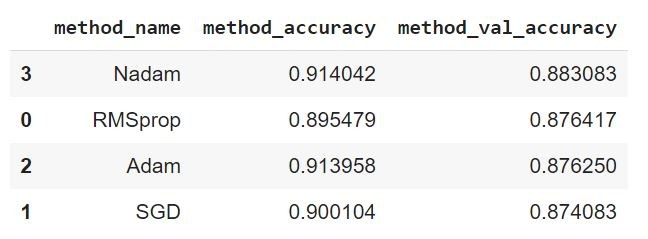

**Вывод**

* Увеличение ширины (количества ядер) может приводить к росту точности. 
* Увеличение глубины (количества слоев) по-разному влияет на точность. 
* Точность полносвязной сети для тестовой выборки в исследуемом наборе данных составляет 0.883, что меньше полученной точности сверточной нейронной сети.